In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
from variational_distributions import MeanField
from advi import ADVI
from metrics import kl_divergence
from init import initialize
import tensorflow_probability.substrates.jax as tfp
import distrax
import optax
from time import time

rc('animation', html='jshtml')
dist = tfp.distributions

In [2]:
import logging
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger = logging.getLogger("root")
logger.addFilter(CheckTypesFilter())

## Coin Toss

### Simulate data

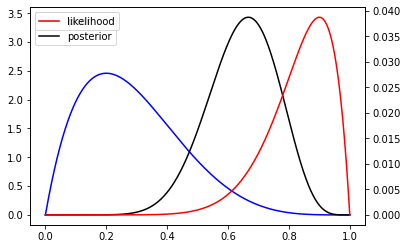

In [3]:
N = 10
n_heads = 9
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
a = 2.0
b = 5.0

gt_prior_dist = dist.Beta(concentration1=a, concentration0=b)
theta = gt_prior_dist.sample(seed=key)
tosses = jnp.array([1] * n_heads + [0] * (N - n_heads))
n_heads = jnp.sum(tosses)
gt_posterior_dist = dist.Beta(jnp.array(a + n_heads), jnp.array(b + N - n_heads))

theta_range = jnp.linspace(0.0, 1.0, 1000)

plt.plot(theta_range, gt_prior_dist.prob(theta_range), color="b", label="prior")
plt.plot(theta_range, gt_posterior_dist.prob(theta_range), color="k", label="posterior")
plt.legend(loc="upper left")

likelihood_fun = jax.jit(jax.vmap(lambda x: jnp.exp(jnp.sum(dist.Bernoulli(probs=x).log_prob(tosses)))))
plt.gca().twinx().plot(theta_range, likelihood_fun(theta_range), label="likelihood", color="r")

plt.legend();

### Model definition

In [4]:
def likelihood_log_prob_fun(sample, data):
    return jnp.sum(dist.Bernoulli(probs=sample).log_prob(data))

model = ADVI(
    prior_dist=gt_prior_dist,
    likelihood_log_prob_fun=likelihood_log_prob_fun,
    data=tosses,
)

variational_dist = MeanField(bijector=distrax.Sigmoid())

### Training

0.74 seconds


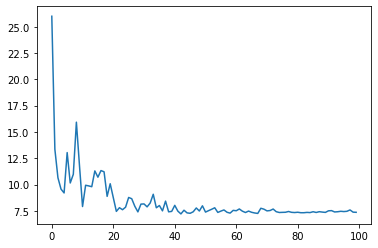

In [5]:
key = jax.random.PRNGKey(0)
n_samples = 10
value_and_grad_fun = jax.jit(jax.value_and_grad(model.objective_fun, argnums=1), static_argnums=2)

variational_dist = initialize(key, variational_dist)

t_init = time()

def inference_loop(rng_key, variational_dist, num_samples):
    @jax.jit
    def one_step(variational_dist, key):
        value, grads = value_and_grad_fun(key, variational_dist, n_samples=n_samples)
        variational_dist = jax.tree_map(lambda p, g: p - 0.01 * g, variational_dist, grads)
        return variational_dist, (variational_dist, value)

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, variational_dist, keys)

    return states

vi_params, losses = inference_loop(key, variational_dist, num_samples=100)

print(f"{time()-t_init:.2f} seconds")
plt.plot(losses);